In [20]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
# import cvxpy as cvx
import os

from util import *
# from data_loader import * 
# from module_deconv import *
# from module_exp import *
from sc_deconv import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation experiments for 1d case#
 - Distrbution estimation 
 - Moments estimation: estimating the first k moments/ mean/ variances, etc. 
 - Denoising 
<br> Here, we assume that we know the support $x$ as well as the sequencing depth $N_r$. The software support two noise models: the poisson model and the binomial model.

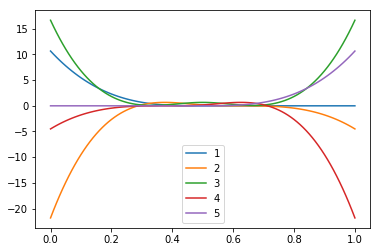

In [2]:
Q=Q_gen(vis=1)

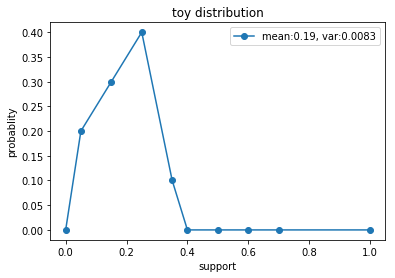

In [38]:
## creating a toy 1d distribution instance
np.random.seed(42)
p,x=toy_dist(vis=1,opt='1d')

[ 2.4   2.15  1.2  -0.7  -5.  ]


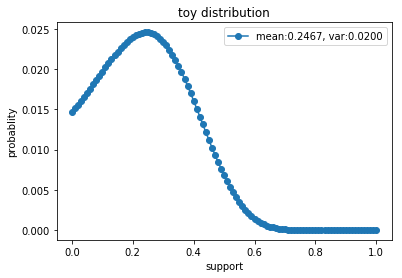

In [4]:
## creating a toy 1d distribution instance
np.random.seed(42)
p,x=toy_dist(vis=1,opt='1d_Q')

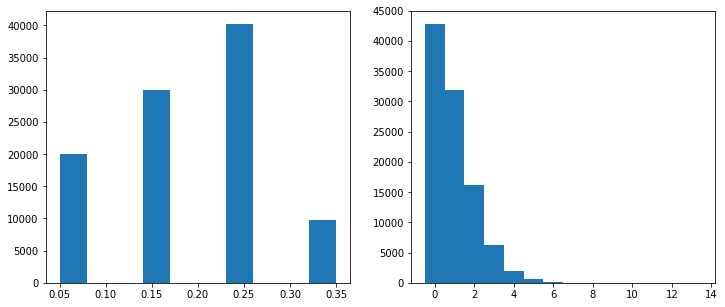

In [39]:
## generate the simulated read count data
N_c=100000
N_r=5
X,Y,data_info=data_gen_1d(p,x,N_c,N_r,noise='poi',vis=1)

### 1. Distribution estimation ###

In [25]:
data_info.keys()

dict_keys(['x', 'p', 'N_c', 'N_r', 'noise'])

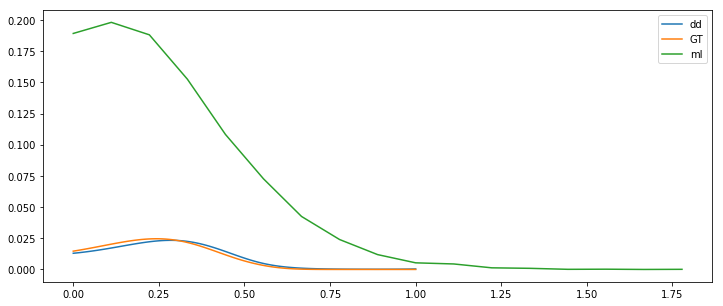

In [27]:
plt.figure(figsize=[12,5])
plt.plot(dd_info['x'],p_hat,label='dd')#,marker='o')
plt.plot(data_info['x'],data_info['p'],label='GT')
plt.plot(ml_info['x'],p_hat_ml,label='ml')
plt.legend()
plt.show()


In [35]:
dd_info

{'N_r': 5.0,
 'Y_pdf': array([4.3343e-01, 3.0192e-01, 1.5811e-01, 6.9230e-02, 2.5910e-02,
        8.2700e-03, 2.2900e-03, 7.1000e-04, 1.1000e-04, 2.0000e-05]),
 'Y_supp': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'alpha': array([ 4.59600276,  3.8063241 ,  1.71144406, -2.12931706, -7.98445385]),
 'x': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ])}

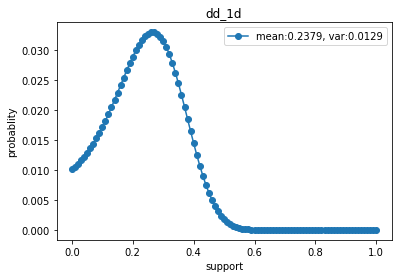

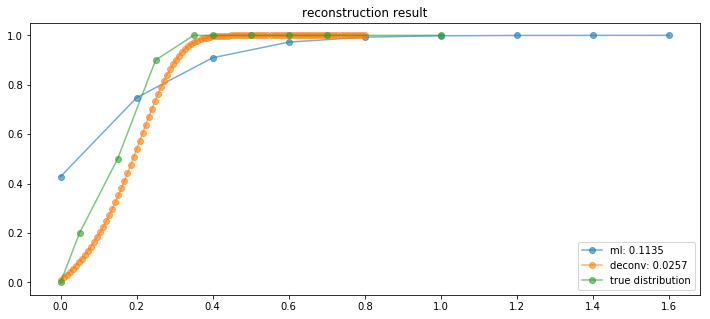

In [40]:
## distribution estimation
# input: Y  
# summary function: Y --> Y_pdf, Y_supp
# specify the scale of x and N_r 

p_hat,dd_info=dd_1d(Y,noise='poi',vis=1,N_r=None)
p_hat_ml,ml_info=ml_1d(Y)
_=plot_result_1d(p,p_hat,p_hat_ml,dd_info,ml_info,data_info)

### 2. Moments estimation ###

In [22]:
mean_hat,var_hat,M_hat,N_r_hat = dd_moments_1d(Y,k=2,noise='poi')
mean_hat,var_hat,M_hat = M_convert(M_hat,N_r_hat,N_r) # converting between the true N_r and the N_r used
print(mean_hat,var_hat,M_hat)

0.24698 0.020104879599999993 [0.24698  0.081104]


### 3. Denoising ### 

In [5]:
## denoising
print 'Empirical estimate MSE:',np.linalg.norm(X-Y/(N_r+0.0))**2/(N_c+0.0)
x_hat_bayes,N_r=denoise_1d(Y,data_info=data_info)
print 'Bayes estimate MSE:',np.linalg.norm(X-x_hat_bayes)**2/(N_c+0.0)
x_hat_eb,N_r_eb=denoise_1d(Y)
print 'EB estimate MSE:',np.linalg.norm(X-GC_convert(x_hat_eb,N_r_eb,N_r))**2/(N_c+0.0)

Empirical estimate MSE: 0.016304
Bayes estimate MSE: 0.00554535018557
EB estimate MSE: 0.00592093602514


### 4. Experiments with parameter sweeping ###

In [17]:
output_folder='./simu_1d'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

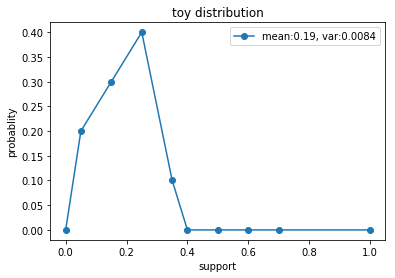

In [25]:
np.random.seed(42)
param_list=[]
# for B in [1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6]:
for B in [1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6]:
# for B in [1e3,1e4,1e5]:
    for N_r in np.linspace(2,100,50,dtype=int):
#     for N_r in np.linspace(1,100,100,dtype=int):
        N_c=np.max([int(B/(N_r+0.0)),1])
        param_list.append([N_c,N_r,int(B)])
param_list=np.array(param_list)
rep_time=100
p,x=toy_dist(vis=1)

In [26]:
res_dd,res_ml=simu_dd(p,x,param_list,rep_time,output_folder)

0.125630011346 0.20695 2 500
0.135452804097 0.113688 4 250
0.136763796788 0.103617670683 6 166
0.126366676599 0.07552 8 125
0.109898512403 0.07254 10 100
0.101901102311 0.0627485943775 12 83
0.0922185751004 0.0587346076459 14 71
0.0910304508445 0.0547677419355 16 62
0.0796551814644 0.0518404040404 18 55
0.0810714167788 0.04785 20 50
0.0698666394348 0.0481484848485 22 45
0.0638974698452 0.0449898373984 24 41
0.0613107583109 0.045751417004 26 38
0.054057871505 0.0416448979592 28 35
0.0515149692929 0.0435171717172 30 33
0.0470600116791 0.041635483871 32 31
0.0502059639796 0.0430612576065 34 29
0.0474152199367 0.0414938271605 36 27
0.0491718546803 0.0415457489879 38 26
0.0436003423934 0.03928 40 25
0.0433306439 0.0387132505176 42 23
0.042756411526 0.0408590909091 44 22
0.0469806929529 0.0421797101449 46 21
0.0418054973889 0.0391583333333 48 20
0.0443838326018 0.03987 50 20
0.0454205197003 0.0397939271255 52 19
0.0443812778221 0.0412888888889 54 18
0.0422142705745 0.0415029411765 56 17
0.04

0.0475539848283 0.0321904847756 48 416
0.0462158724075 0.032085 50 400
0.0462520604455 0.0313923277244 52 384
0.0463815647574 0.0311372372372 54 370
0.0458712595444 0.0308947979192 56 357
0.045976548858 0.0307610866079 58 344
0.0450717660283 0.0296706706707 60 333
0.0441203954939 0.0301095171308 62 322
0.0460325179472 0.0296502804487 64 312
0.0449537835733 0.0296471647165 66 303
0.0448891475203 0.0293472789116 68 294
0.0447116630493 0.0296476190476 70 285
0.0445107865899 0.0286183313277 72 277
0.0443456955148 0.0285301301301 74 270
0.0442124734372 0.0283696617971 76 263
0.0434059043061 0.02835078125 78 256
0.0421039597395 0.0276095 80 250
0.0442769817286 0.0284392753187 82 243
0.0427909603082 0.027669047619 84 238
0.0427063624585 0.0277554931836 86 232
0.0427283618594 0.0278619343212 88 227
0.042911477637 0.0278704704705 90 222
0.0433011733301 0.0273433780805 92 217
0.0417887668746 0.0272630871136 94 212
0.0429372963892 0.0274036658654 96 208
0.0416672490924 0.0271537414966 98 204
0.04

0.024875764222 0.0281041596659 74 6756
0.0248822608338 0.0277680866045 76 6578
0.0248710571926 0.0275996039842 78 6410
0.0248086829756 0.02721438 80 6250
0.02471833822 0.0274073134728 82 6097
0.0247167818066 0.027079109063 84 5952
0.0245799796125 0.0269829211991 86 5813
0.0246247602257 0.0267126346194 88 5681
0.0246121757757 0.0267896189619 90 5555
0.0246332230575 0.0265204869501 92 5434
0.024474154216 0.0263496657906 94 5319
0.0245447066129 0.0262353870648 96 5208
0.0242870735293 0.0260821366571 98 5102
0.0242757771814 0.0258113 100 5000
0.0318567661599 0.20775882 2 500000
0.0283539245971 0.110169936 4 250000
0.027759778052 0.102405925624 6 166666
0.0273032431878 0.07414085 8 125000
0.0267406022021 0.07152248 10 100000
0.0259295226891 0.0624433397734 12 83333
0.0252226802746 0.0574124492996 14 71428
0.0250155205489 0.052926282 16 62500
0.0247290376141 0.0507044870449 18 55555
0.0246808737164 0.04206271 20 50000
0.0247491420841 0.0438926307116 22 45454
0.0246558672644 0.0419108605738 2